### (Optional) Install Neural A* on Colab

We highly recommend the use of GPUs for faster training/planning.

In [5]:
!git clone --recursive https://github.com/omron-sinicx/neural-astar

Cloning into 'neural-astar'...
remote: Enumerating objects: 424, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 424 (delta 53), reused 40 (delta 40), pack-reused 352
Receiving objects: 100% (424/424), 11.23 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (179/179), done.
Submodule 'planning-datasets' (https://github.com/omron-sinicx/planning-datasets) registered for path 'planning-datasets'
Cloning into '/home/at83yvah/neural-astar/notebooks/neural-astar/planning-datasets'...
remote: Enumerating objects: 51, done.        
remote: Counting objects: 100% (10/10), done.        
remote: Compressing objects: 100% (8/8), done.        
remote: Total 51 (delta 4), reused 4 (delta 2), pack-reused 41        
Receiving objects: 100% (51/51), 58.10 MiB | 21.35 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Submodule path 'planning-datasets': checked out '7f8953c4b0f511c2cc03410abfdb3687d54deafb'
Submodule 'data/mpd/original' (ht

In [ ]:
%cd neural-astar
!pip install -U pip setuptools
!pip install .

[Errno 2] No such file or directory: 'neural-astar'
/home/at83yvah/neural-astar/notebooks/neural-astar


/home/at83yvah/.local/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


Found existing installation: numpy 2.0.0
Uninstalling numpy-2.0.0:
  Would remove:
    /home/at83yvah/.local/bin/f2py
    /home/at83yvah/.local/bin/numpy-config
    /home/at83yvah/.local/lib/python3.9/site-packages/numpy-2.0.0.dist-info/*
    /home/at83yvah/.local/lib/python3.9/site-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /home/at83yvah/.local/lib/python3.9/site-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /home/at83yvah/.local/lib/python3.9/site-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /home/at83yvah/.local/lib/python3.9/site-packages/numpy/*
Proceed (Y/n)? 

## Shortest path search with Neural A* 

Neural A\*, as well as vanilla differentiable A\* can be instantiated just like a neural network module.

In [7]:
import torch
from neural_astar.planner import NeuralAstar, VanillaAstar
from neural_astar.utils.training import load_from_ptl_checkpoint

device = "cuda" if torch.cuda.is_available() else "cpu"

neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar.load_state_dict(load_from_ptl_checkpoint("../model/mazes_032_moore_c8/lightning_logs/"))

vanilla_astar = VanillaAstar().to(device)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib64/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib64/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/at83yvah/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/at83yvah/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/at83yvah/.local/lib/python3.9/sit

IndexError: list index out of range

Running these A\* modules requires `map_designs` (obstacle layouts), `start_maps`, and `goal_maps` (one-hot maps indicating start and goal locations), which should each have the shape of `(batch_size, 1, map_size, map_size)`.

In [ ]:
import matplotlib.pyplot as plt
from neural_astar.utils.data import create_dataloader

dataloader = create_dataloader("../planning-datasets/data/mpd/mazes_032_moore_c8.npz", "test", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))

fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")

Then, search can be performed by simply forwarding the model. The output is namedtuple `AstarOutput` with `histories` (search history maps) and `paths` (path maps).

/home/yonetani/programs/omron-sinicx/neural-astar/.venv/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(-0.5, 273.5, 35.5, -0.5)

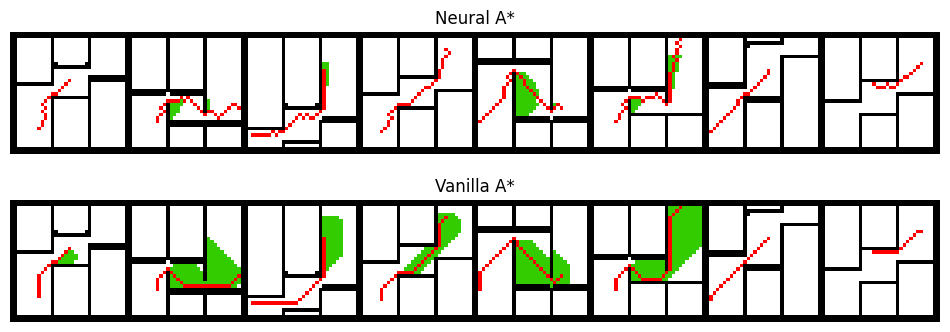

In [3]:
from neural_astar.utils.data import visualize_results

neural_astar.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
vanilla_astar.eval()
va_outputs = vanilla_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))

fig, axes = plt.subplots(2, 1, figsize=[12, 4])
axes[0].imshow(visualize_results(map_designs, na_outputs))
axes[0].set_title("Neural A*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, va_outputs))
axes[1].set_title("Vanilla A*")
axes[1].axis("off")